In [1]:
import sys, yaml
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.optimize import minimize, Bounds
from motoman_def import *

In [51]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def avg_by_line(job_line, flame_pos, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty((num_segs, 3))
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i,:] = average_pos[idx, :]
         else:
              output[i,:] = [None, None, None]
    #handle missing height data

    return output

class speedHeightModel:
    '''
    Model relating dh to torch speed according to the equation
    ln(h) = a ln(v) + b
    '''
    def __init__(self, lam = 1, coeff_mat = [-0.4619, 1.647]):
        self.coeff_mat = np.array(coeff_mat)
        self.lam = lam
        self.P = np.diag(np.ones(self.coeff_mat.shape[0])*self.lam)
    
    def v2dh(self, v):
        logdh = self.coeff_mat[0]*np.log(v)+self.coeff_mat[1]
    
        dh = np.exp(logdh)
        return dh
    
    def dh2v(self, dh):
        logdh = np.log(dh)
        logv = (logdh-self.coeff_mat[1])/self.coeff_mat[0]
        
        v = np.exp(logv)
        return v
    
    def model_update(self, vels, dhs, weight):
        # Updates the model with new height-torchspeed data
        ln_vels = np.log(np.array(vels))
        ln_dhs = np.log(np.array(dhs))

        # check for nan values in ln(dhs)
        idxs = np.argwhere(np.isnan(ln_dhs))
        ln_dhs = np.delete(ln_dhs, idxs)
        ln_vels = np.delete(ln_vels, idxs)

        # Pseudo-inverse to calculate least squares fit based on new data
        x_mat = np.vstack((ln_vels, np.ones_like(ln_vels)))

        updated_coeff_mat = ln_dhs@np.linalg.pinv(x_mat)
        # print(updated_coeff_mat)
        # print(self.coeff_a)
        # print(self.coeff_b)
        # Model Update
        self.coeff_mat = weight*updated_coeff_mat + (1-weight)*self.coeff_mat
        # else:
        # print(self.coeff_a)
        # print(self.coeff_b)

    def model_update_RLS(self, vels, dhs):
        # Algorithm from https://osquant.com/papers/recursive-least-squares-linear-regression/
        for idx,vel in enumerate(vels):
            x  = np.array([[np.log(np.array(vel))], [1]])
            y = np.log(dhs[idx])
            if not np.isnan(y):
                print("X: ",x.shape)
                print("W: ", self.coeff_mat.shape)
                y = np.log(dhs[idx])
                r = 1+x.T@self.P@x

                k = self.P@x/r
                e = y-x.T@self.coeff_mat
                self.coeff_mat = self.coeff_mat+k@e
                self.P = self.P-k@k.T*r






In [6]:
dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/'
H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')

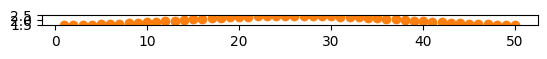

Original coeff mat:  [-0.4619  1.647 ]
new coeff mat:  [0. 0.]
[15.01041783 14.9260423  14.67832846 14.28275429 13.7627658  13.14682879
 12.46524938 11.74732877 11.01922848 10.30268921  9.61454803  8.96687771
  8.36753049  7.82088503  7.32864236  6.89057043  6.50514411  6.17006212
  5.88264402  5.64012246  5.43984988  5.27943935  5.15685679  5.07047888
  5.0191277   5.00209019  5.0191277   5.07047888  5.15685679  5.27943935
  5.43984988  5.64012246  5.88264402  6.17006212  6.50514411  6.89057043
  7.32864236  7.82088503  8.36753049  8.96687771  9.61454803 10.30268921
 11.01922848 11.74732877 12.46524938 13.14682879 13.7627658  14.28275429
 14.67832846 14.9260423 ]


In [8]:
layer = 55

with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
    flame_3d = pickle.load(file)
with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
    job_no = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
    flame_3d_prev = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
    job_no_prev = pickle.load(file)

vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
job_no = [i-4 for i in job_no]
job_no_prev = [i-4 for i in job_no_prev]

p = H[:3, -1]
R = H[:3, :3]

for i in range(flame_3d.shape[0]):
    flame_3d[i] = R.T@flame_3d[i]
for i in range(flame_3d_prev.shape[0]):
    flame_3d_prev[i] = R.T@flame_3d_prev[i]

layer_angle = angle*(layer-1)

layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z-base_thickness
new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
flame_3d_prev[:,0] = new_x
flame_3d_prev[:,2] = new_z-base_thickness
averages = avg_by_line(job_no, flame_3d, 50)
heights = averages[:,-1]
averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
heights_prev = averages_prev[:,-1]

# Check Direction Flags so directions match
if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
    heights = heights[::-1]
    vel_profile = vel_profile[::-1]
if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
    heights_prev = heights_prev[::-1]

dh = heights-heights_prev
model = speedHeightModel()
dh_model = model.v2dh(vel_profile)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.linspace(1,50,50), dh)
ax.scatter(np.linspace(1,50,50), dh_model)
ax.set_aspect('equal')
plt.show()

print("Original coeff mat: ", model.coeff_mat) 
model.model_update(vel_profile[1:-2], dh[1:-2], weight=1)
print("new coeff mat: ", model.coeff_mat) 
print(vel_profile)

C:\Users\armor\AppData\Local\Temp\ipykernel_24568\4280490398.py:100: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


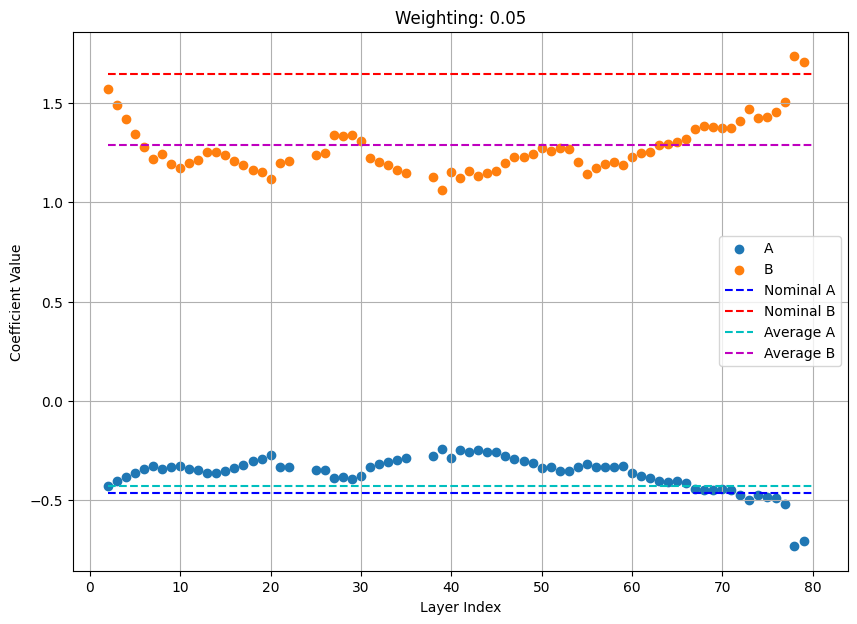

Max A:  0.5627018481319419
Min A:  -4.808978824660464
Max B:  6.13547219396239
Min B:  -0.4316918457709632


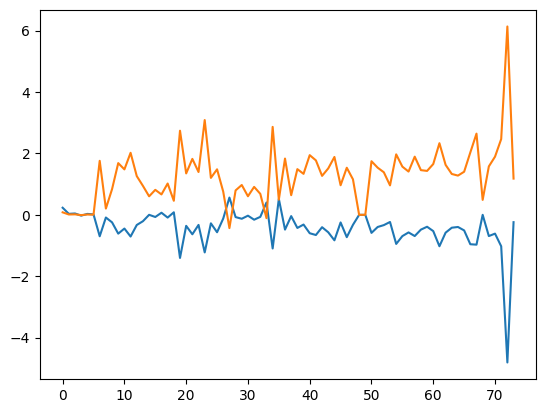

In [11]:
layer_start = 2
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
model = speedHeightModel()
model_each_layer = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
for layer in range(layer_start,80):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)

        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
        job_no = [i-4 for i in job_no]
        job_no_prev = [i-4 for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]

        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)

        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        weight = 0.05
        model.model_update(vel_profile[1:-2], dh[1:-2], weight=weight)
        model_each_layer.model_update(vel_profile[1:-2], dh[1:-2], weight = 1)
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])
        coeff_a_total.append(model_each_layer.coeff_mat[0])
        coeff_b_total.append(model_each_layer.coeff_mat[1])

    except IndexError:
        coeff_a.append(None)
        coeff_b.append(None)
        pass

average_a = np.average(coeff_a_total)
average_b = np.average(coeff_b_total)

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_a, average_a], 'c--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_b, average_b], 'm--')
plt.legend(("A", "B", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Weighting: {weight}")
plt.show()

plt.plot(coeff_a_total)
plt.plot(coeff_b_total)
print("Max A: ", max(coeff_a_total))
print("Min A: ", min(coeff_a_total))
print("Max B: ", max(coeff_b_total))
print("Min B: ", min(coeff_b_total))

np.savetxt("model_coeffs_real.csv", np.array([coeff_a_total, coeff_b_total]).T, delimiter=',')

X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)


C:\Users\armor\AppData\Local\Temp\ipykernel_24568\4110033834.py:126: RuntimeWarning: invalid value encountered in log
  y = np.log(dhs[idx])


X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
X:  (2, 1)
W:  (2,)
too many indices for array: array is 1-dimensional, but 2 we

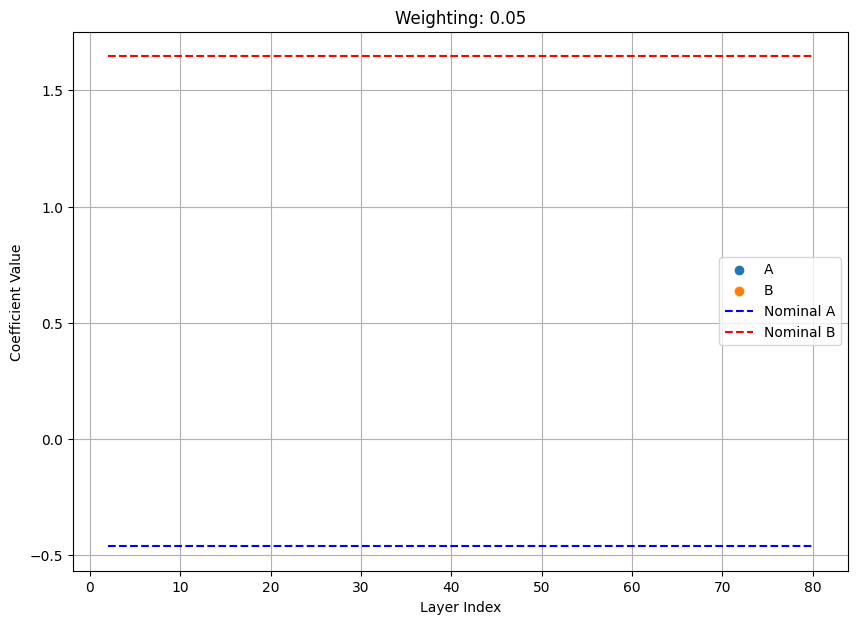

In [53]:
layer_start = 2
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
model = speedHeightModel()
model_each_layer = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
for layer in range(layer_start,80):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)

        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
        job_no = [i-4 for i in job_no]
        job_no_prev = [i-4 for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]

        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)

        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        model.model_update_RLS(vel_profile[1:-2], dh[1:-2])
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])

    except IndexError as e:
        print(e)
        coeff_a.append(None)
        coeff_b.append(None)
        pass

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.legend(("A", "B", "Nominal A", "Nominal B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Weighting: {weight}")
plt.show()

In [ ]:
start_times = []
start_part = None
for layer in range(1,80):
    times = np.loadtxt(save_path+f'layer_{layer}/weld_js_exe.csv', delimiter=',')
    if layer == 1: start_part = times[0,0]
    start_times.append(times[0,0])
    


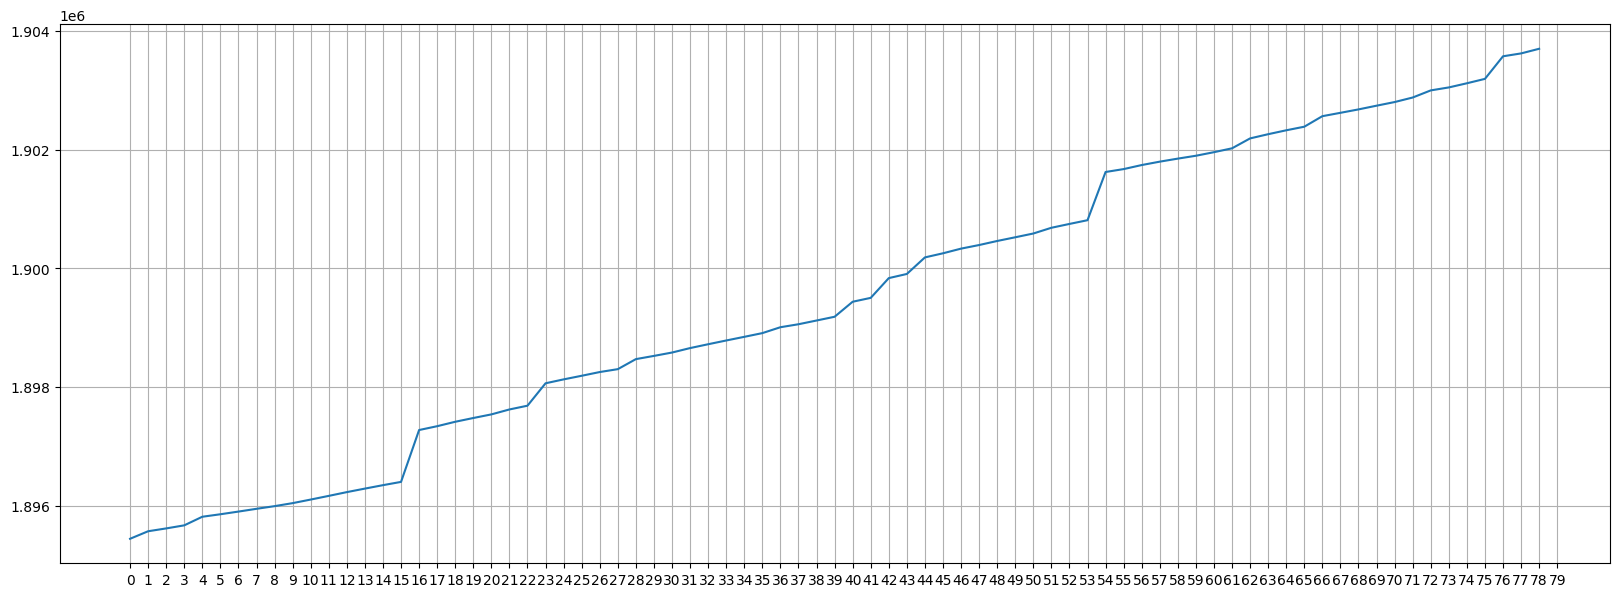

In [ ]:
plt.plot(start_times)
plt.gcf().set_size_inches(20,7)
plt.gca().grid()
start, end = plt.gca().get_xlim()
plt.gca().xaxis.set_ticks(range(0, 80, 1))
plt.show()